In [1]:
import pandas as pd
import numpy as np
import os


In [2]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train.pkl")
X_val = pd.read_pickle("../../data/interim/X_val.pkl")
X_test = pd.read_pickle("../../data/interim/X_test.pkl")
y_train = pd.read_pickle("../../data/interim/y_train.pkl")
y_val = pd.read_pickle("../../data/interim/y_val.pkl")
y_test = pd.read_pickle("../../data/interim/y_test.pkl")

### Segment into Windows

In [3]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(X, y, window_size=100, step_size=50):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

In [4]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

### Encode Label

In [5]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Attention, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming X_train is your training data with shape: (num_samples, window_length, num_channels)
# Example:
#    window_length = 25 (time steps)
#    num_channels = 6 (sensor channels)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])
num_classes = len(np.unique(y_train))
# Input layer
inputs = Input(shape=input_shape)

# --- CNN Blocks ---
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

# --- LSTM Layer ---
# return_sequences=True is important to preserve the temporal structure for the attention layer.
x = LSTM(64, return_sequences=True)(x)

# --- Self-Attention ---
# The Attention layer computes a weighted sum of the LSTM outputs.
# Using the same tensor for queries and keys/values implements self-attention.
attn_output = Attention()([x, x])
# Optionally, you can combine the attention output with the LSTM output.
# Here, we simply use the attention output further.
x = GlobalAveragePooling1D()(attn_output)

# --- Dense Layers for Classification ---
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100, 6)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 100, 64)   │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 100, 128)  │     24,704 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 50, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 50, 128)   │     49,280 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50, 64)    │     49,408 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 50, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,808 (507.06 KB)

 Trainable params: 129,808 (507.06 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.7131 - loss: 0.9648 - val_accuracy: 0.7751 - val_loss: 0.6680
Epoch 2/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8727 - loss: 0.3851 - val_accuracy: 0.8052 - val_loss: 0.5149
Epoch 3/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8946 - loss: 0.3103 - val_accuracy: 0.7878 - val_loss: 0.6220
Epoch 4/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9067 - loss: 0.2706 - val_accuracy: 0.8158 - val_loss: 0.5023
Epoch 5/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9132 - loss: 0.2472 - val_accuracy: 0.8151 - val_loss: 0.5217
Epoch 6/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9186 - loss: 0.2262 - val_accuracy: 0.8319 - val_loss: 0.5372
Epoch 7/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9241 - loss: 0.2129 - val_accuracy: 0.8189 - val_loss: 0.5646
Epoch 8/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.9295 -

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 1.1054
Test Accuracy: 0.8266
560/560 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step


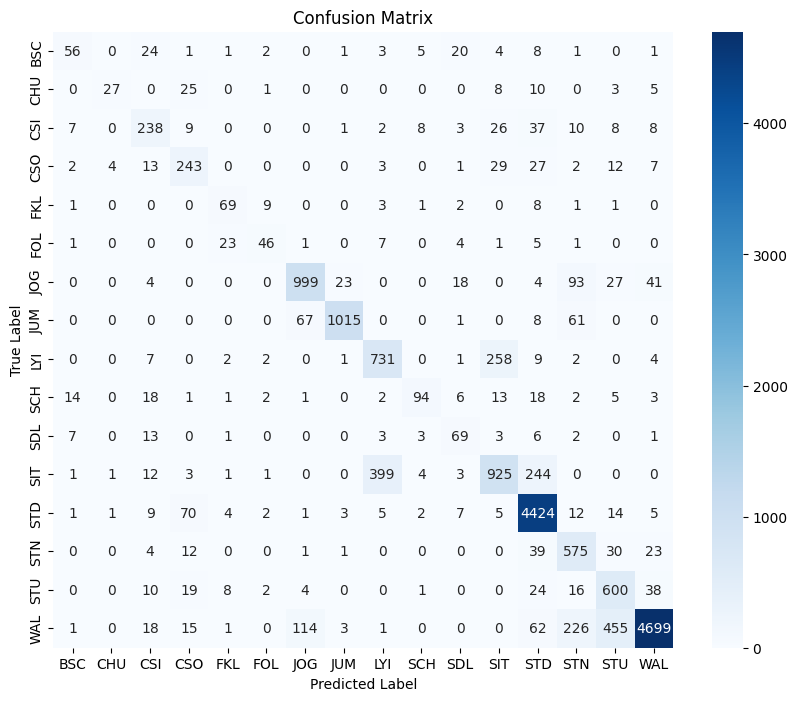

Classification Report:
               precision    recall  f1-score   support

         BSC       0.62      0.44      0.51       127
         CHU       0.82      0.34      0.48        79
         CSI       0.64      0.67      0.65       357
         CSO       0.61      0.71      0.66       343
         FKL       0.62      0.73      0.67        95
         FOL       0.69      0.52      0.59        89
         JOG       0.84      0.83      0.83      1209
         JUM       0.97      0.88      0.92      1152
         LYI       0.63      0.72      0.67      1017
         SCH       0.80      0.52      0.63       180
         SDL       0.51      0.64      0.57       108
         SIT       0.73      0.58      0.65      1594
         STD       0.90      0.97      0.93      4565
         STN       0.57      0.84      0.68       685
         STU       0.52      0.83      0.64       722
         WAL       0.97      0.84      0.90      5595

    accuracy                           0.83     17917
  

In [10]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model, X_test_windows, y_test_windows_encoded, label_classes=label_classes)
